# Weekly assignment 4: machine learning
## 1. Introduction
In this assignment I am going to apply what I learned about machine learning to the dataset Gender recognition of voice from Kaggle. I am going to predict the outcomes of the dataset using Random Forest.

The aim of this exercise is to predict the variable *label* (male or female). To do this, we will first remove the variables that do not directly influence what we are trying to predict and create a dataframe to work with. Then I will look for interesting relationships between the variables. After that, I will build a predictive model using Random Forest and evaluate the results by calculating the accuracy, the precision and the recall. I will end this Notebook with a conclusion.



In [40]:
import seaborn as sns
import sklearn as sk
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #We need this to split the data

## 2. Data set
Let's first look at the dataset and see which variables we can use.

In [41]:
df = pd.read_csv("voice.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

* *meanfreq*: mean frequency (in kHz)
* *sd*: standard deviation of frequency
* *median*: median frequency (in kHz)
* *Q25*: first quantile (in kHz)
* *Q75*: third quantile (in kHz)
* *IQR*: interquantile range (in kHz)
* *skew*: skewness
* *kurt*: kurtosis 
* *sp.ent*: spectral entropy
* *sfm*: spectral flatness
* *mode*: mode frequency
* *centroid*: frequency centroid
* *peakf*: peak frequency (frequency with highest energy)
* *meanfun*: average of fundamental frequency measured across acoustic signal
* *minfun*: minimum fundamental frequency measured across acoustic signal
* *maxfun*: maximum fundamental frequency measured across acoustic signal
* *meandom*: average of dominant frequency measured across acoustic signal
* *mindom*: minimum of dominant frequency measured across acoustic signal
* *maxdom*: maximum of dominant frequency measured across acoustic signal
* *dfrange*: range of dominant frequency measured across acoustic signal
* *modindx*: modulation index.
* *label*: male or female

The following 7 variables (excluding *label*) might be of interest for our case:
* *meanfreq*: mean frequency (in kHz)
* *sd*: standard deviation of frequency
* *median*: median frequency (in kHz)
* *IQR*: interquantile range (in kHz)
* *meanfun*: average of fundamental frequency measured across acoustic signal
* *meandom*: average of dominant frequency measured across acoustic signal
* *dfrange*: range of dominant frequency measured across acoustic signal
* *label*: male or female

We can remove the ones that are not going to be useful.

## 3. Data cleaning

### 3.1 Create new dataframe

Let's select the variables we need and create a new dataframe.

In [42]:
df = df[['meanfreq','sd', 'median', 'IQR', 'meanfun', 'meandom','dfrange','label']]

In [43]:
df.head()

,meanfreq,sd,median,IQR,meanfun,meandom,dfrange,label
0,0.059781,0.064241,0.032027,0.075122,0.084279,0.007812,0.000000,male
1,0.066009,0.067310,0.040229,0.073252,0.107937,0.009014,0.046875,male
2,0.077316,0.083829,0.036718,0.123207,0.098706,0.007990,0.007812,male
3,0.151228,0.072111,0.158011,0.111374,0.088965,0.201497,0.554688,male
4,0.135120,0.079146,0.124656,0.127325,0.106398,0.712812,5.476562,male


### 3.2 Create dummy variables
Let's add dummy variables for the variable *label*. Following this, only the male variable will be used.

In [44]:
dummies = pd.get_dummies(df['label'])
df = pd.concat([df, dummies], axis=1)
df.head()

,meanfreq,sd,median,IQR,meanfun,meandom,dfrange,label,female,male
0,0.059781,0.064241,0.032027,0.075122,0.084279,0.007812,0.000000,male,0,1
1,0.066009,0.067310,0.040229,0.073252,0.107937,0.009014,0.046875,male,0,1
2,0.077316,0.083829,0.036718,0.123207,0.098706,0.007990,0.007812,male,0,1
3,0.151228,0.072111,0.158011,0.111374,0.088965,0.201497,0.554688,male,0,1
4,0.135120,0.079146,0.124656,0.127325,0.106398,0.712812,5.476562,male,0,1


## 4. Exploratory data analysis
### 4.1 Dependent variable

In [45]:
df['label'].value_counts()

female    1584
male      1584
Name: label, dtype: int64

We can see that there are the same number of female and male records.
### 4.2 Relation between numerical variables
Let's have a look at the relations between the numerical variables using a scatterplot matrix.

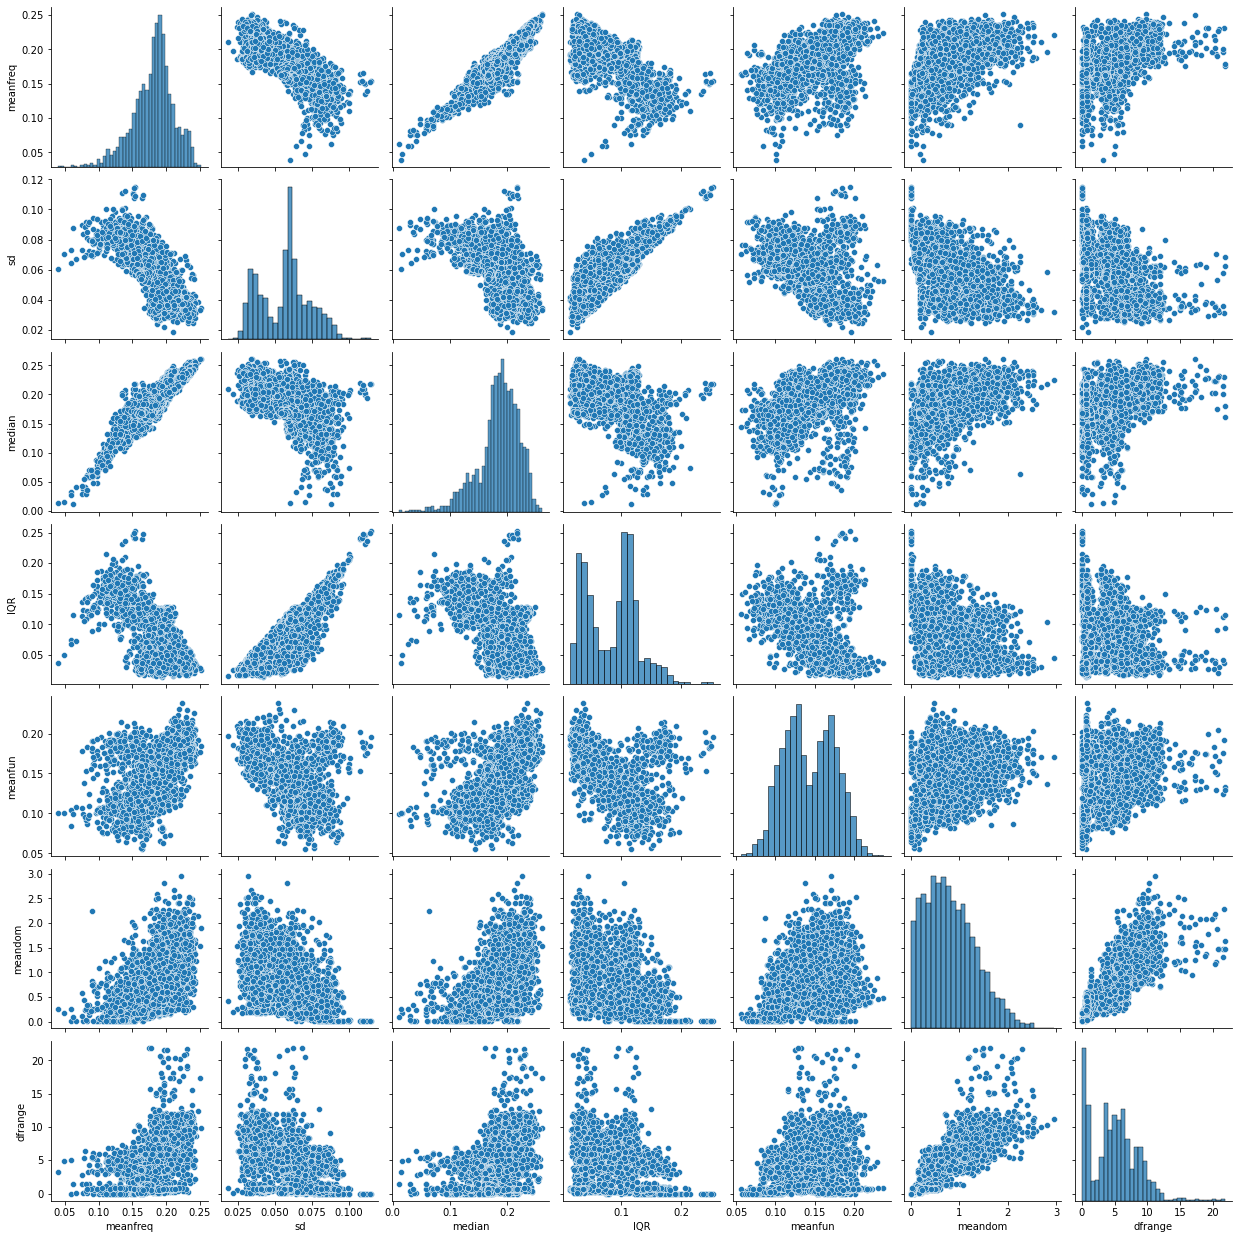

In [46]:
df_numerical = df[['meanfreq','sd', 'median', 'IQR', 'meanfun', 'meandom','dfrange']]
sns.pairplot(df_numerical)
plt.show()

We can see that there are linear correlations between _sd_ and _IQR_ and between _meanfreq_ and _median_. The last one is to be expected since it is the mean and median of the frequency. The correlation between _sd_ and _IQR_ is misleading because the _IQR_ values do not seem to exceed a certain threshold. This is subject to misinterpretation. 

### 4.3 Relation of variable male/female with numerical variables
Let's now take a look at the correlations between the male or female variables and the other numerical variables.

In [47]:
df_numerical.corr()

,meanfreq,sd,median,IQR,meanfun,meandom,dfrange
meanfreq,1.000000,-0.739039,0.925445,-0.627605,0.460844,0.536666,0.515570
sd,-0.739039,1.000000,-0.562603,0.874660,-0.466281,-0.482726,-0.475999
median,0.925445,-0.562603,1.000000,-0.477352,0.414909,0.455943,0.435621
IQR,-0.627605,0.874660,-0.477352,1.000000,-0.534462,-0.333362,-0.331563
meanfun,0.460844,-0.466281,0.414909,-0.534462,1.000000,0.270840,0.275154
meandom,0.536666,-0.482726,0.455943,-0.333362,0.270840,1.000000,0.811304
dfrange,0.515570,-0.475999,0.435621,-0.331563,0.275154,0.811304,1.000000


According to the table, the variables _meanfun_ (0.83) and _IQR_ (0.61) seem to have the highest correlation with the variables _male_ and _female_. This means that _meanfun_ can be used for prediction.

## 5. Predictive model using Random Forest
### 5.1 Explanation Random Forest
For this section of the assignment I am going to use Random Forest. It consists of several decision trees that independently predict the same thing. The results of the decision trees are combined and the average of the results is the final result.
### 5.2 Build the model
#### 5.2.1 Split the data
Here I split the data set into a training and test set in order to train the model. I choose the _male_ variable as the y-variable since we are trying to predict the _label_ variable. As this is dummy data I cannot use the _male_ and _female_ variables at the same time.

In [48]:
X = df_numerical #create the X matrix

y = df['male'] #create the y-variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #split the data, store it into different variables

X_train.head() #show the head of the training set

,meanfreq,sd,median,IQR,meanfun,meandom,dfrange
1866,0.141083,0.088698,0.179804,0.174542,0.174179,0.633333,3.585938
767,0.167021,0.057011,0.187109,0.100853,0.100181,0.352539,2.359375
2862,0.234486,0.034413,0.240764,0.028535,0.179095,1.779255,8.742188
1064,0.197073,0.057609,0.217386,0.105827,0.138659,1.199707,7.992188
270,0.142018,0.071383,0.139775,0.108663,0.108932,0.247944,4.742188


#### 5.2.2 Train the model
Now I am going to train the model by using Random Forest.

In [49]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

## 6. Evaluation
In order to verify the performance of the model, I am going to calculate the accuracy, the precision and the recall. The accuracy corresponds to the portion that is correclty predicted. The precision is how much of the predicted result is actually this result. The recall is how much of the real results is well predicted.
### 6.1 Accuracy
Let's start by calculating accuracy. As always, this is done with the test data.

In [50]:
rfc.score(X_test, y_test) #calculate the fit on the *test* data

0.9758149316508938

The accuracy is 97.58%. To see if the model is good I compare it with the best baseline guess: always guess "Female". That would give the following calculation (see *4.1 Dependent variable*):

$\frac{1584}{(1584 + 1584)}=50$ %

This means that the model is a lot better than the baseline guess.

### 6.2 Precision and recall
Aside from accuracy, I also look at precision and recall. Let's create a confusion matrix for that.

In [51]:
from sklearn.metrics import confusion_matrix
y_test_pred = rfc.predict(X_test) #the predicted values
cm = confusion_matrix(y_test, y_test_pred) #creates a "confusion matrix"
cm

array([[449,   8],
       [ 15, 479]], dtype=int64)

In order to know what corresponds to what I use rfc.classes_.

In [52]:
rfc.classes_

array([0, 1], dtype=uint8)

rfc.classes_ shows the label. 0 is *female* and 1 is *male*.

In [53]:
conf_matrix = pd.DataFrame(cm, index=['Female (actual)', 'Male (actual)'], columns = ['Female (predicted)', 'Male (predicted)']) 
conf_matrix

,Female (predicted),Male (predicted)
Female (actual),449,8
Male (actual),15,479


450 out of the 465 predicted female where actual female. 479 out of the 486 predicted male where actual male.
The confusion matrix corresponds well to the accuracy calculated earlier. The results are consistent.

In [54]:
from sklearn.metrics import classification_report

for i in range(1,11):
    rfc_new = RandomForestClassifier(i) #make a new Forest model with i (1-10) decision trees
    rfc_new = rfc_new.fit(X_train, y_train) #fit new model on train data
    y_test_pred_new = rfc_new.predict(X_test) #predict using new model, with test data
    print(f"With {i} decision trees the result is:")
    print(classification_report(y_test, y_test_pred_new)) #use a built-in function to print out accuracy, precision and recall


With 1 decision trees the result is:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       457
           1       0.97      0.95      0.96       494

    accuracy                           0.96       951
   macro avg       0.96      0.96      0.96       951
weighted avg       0.96      0.96      0.96       951

With 2 decision trees the result is:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       457
           1       0.98      0.92      0.95       494

    accuracy                           0.95       951
   macro avg       0.95      0.95      0.95       951
weighted avg       0.95      0.95      0.95       951

With 3 decision trees the result is:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       457
           1       0.97      0.97      0.97       494

    accuracy                           0.97       951
   macro avg     

With 6 decision trees the precision and recall are the closest to 1. The f1-score is 98%. It represents the harmonic mean of the precision and recall. This means that by using 6 decision trees the model can most accurately predict whether a voice is male or female.

## 7. Conclusion

In this assignment I tried to create a model using Random Forest in order to identify a voice as male or female.


First I created a dataframe with the necessary variables and transformed the variables in dummy variables when needed. Then I checked if there were any interesting relationships between the variables. Between the numerical variables there was nothing interesting, but between the numerical variables and the _male_/_female_ variables there was. In particular with the _meanfun_. Afterwards I built the predictive model using Random Forest by splitting the dataset into a train and test set. I trained the model with the train set. Finally I evaluated my model using the test set. The results were very promising because by using 6 decision trees I arrived at an f1-score of 98%. It is very likely that these results are as they are because of the variable _meanfun_. In 98% of the cases, the predictions of my model are correct.